In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random

### 2D Point Mass Continous dynamics

In [3]:
c = 0.0
m = 1.0
function point_mass(x, u)
   # x = state[1]                #x_1 = ẋ
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    #y = state[3]
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

### Linearizing and discretizing the dynamics

In [4]:
function lin_dyn_discrete(dynamics, x, u, dt)
    A = ForwardDiff.jacobian(dx -> dynamics(dx, u), x)
    B = ForwardDiff.jacobian(du -> dynamics(x, du), u)
    A = dt .* A + I
    B = dt .* B
    return A, B
end
x = [0; 0; 0 ;0]
u = [0; 0];

In [5]:
A1, B1 = lin_dyn_discrete(point_mass, x, u, 0.01)
A2, B2 = lin_dyn_discrete(point_mass, x, u, 0.01)
A = blockdiag(sparse(A1), sparse(A2))
B1Shape = size(B1)
B2Shape = size(B2)
B1 = [sparse(B1); zeros(B2Shape)]
B2 = [zeros(B1Shape); B2]

8×2 Matrix{Float64}:
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.01  0.0
 0.0   0.01

### Cost function

In [6]:
# Constraint 
obstacle = [10.0, 10.0, 0.0, 0.0]
dmax = 2.0
ρ = 500.0
# Q = 0.1*I(4) #state cost for point mass 1
# R = 10.0*I(2)
# Qn = 10.0*I(4)
function cost(Qi, Rii, Rij, Qni, x, ui, uj, xgoal, uigoal, ujgoal, B)

    goal = x - xgoal# check x or x̂
    rel_dist = (x[1:2] - x[5:6])'*I*(x[1:2] - x[5:6])
    if B 
        return 0.5*goal'*Qni*goal #+ ρ/(exp(rel_dist))
    else            
        dx = x - xgoal
        dui = ui - uigoal
        duj = uj - ujgoal
#         c = (rel_dist - dmax)
#         if c < 0
#             c = 0.0000000000000001
#         end

        return 0.5*(dx'*Qi*dx + dui'*Rii*dui + duj'*Rij*duj) + ρ*(min(sqrt(rel_dist) - dmax, 0))^2 #- (ρ)*log2(c)
        
    end
end

cost (generic function with 1 method)

## Quadriticize the cost function

In [7]:
function quadratic_cost(cost_fun, Qi, Rii, Rij, Qni, x, ui, uj, xgoal, uigoal, ujgoal, B)
    """
    2nd order Taylor expansion of cost at t
    I neglected the mixed paritals in the hessian
    """
    Q̂i = ForwardDiff.hessian(dx -> cost_fun(Qi, Rii, Rij, Qni, dx, ui, uj, xgoal, uigoal, ujgoal, B), x)
    l̂i = ForwardDiff.gradient(dx -> cost_fun(Qi, Rii, Rij, Qni, dx, ui, uj, xgoal, uigoal, ujgoal, B), x)
    R̂ii = ForwardDiff.hessian(du -> cost_fun(Qi, Rii, Rij, Qni, x, du, uj, xgoal, uigoal, ujgoal, B), ui)
    r̂ii = ForwardDiff.gradient(du -> cost_fun(Qi, Rii, Rij, Qni, x, du, uj, xgoal, uigoal, ujgoal, B), ui)
    R̂ij = ForwardDiff.hessian(du -> cost_fun(Qi, Rii, Rij, Qni, x, ui, du, xgoal, uigoal, ujgoal, B), uj)
    r̂ij = ForwardDiff.gradient(du -> cost_fun(Qi, Rii, Rij, Qni, x, ui, du, xgoal, uigoal, ujgoal, B), uj)

    if B
        dx = x - xgoal
        dui = zeros(size(ui))
        duj = zeros(size(uj))
    else
        dx = x - xgoal
        dui = ui - uigoal
        duj = uj - ujgoal
    end
    cost = 0.5 * dx' * (Q̂i*dx + 2*l̂i) + 0.5 * dui' * (R̂ii*dui + 2*r̂ii) + 0.5 * duj' * (R̂ij*duj + 2*r̂ij)
    return cost, Q̂i, l̂i, R̂ii, r̂ii, R̂ij, r̂ij
end

quadratic_cost (generic function with 1 method)

## Create costs for the 2 players

In [8]:
Q1 = sparse(zeros(8,8)) #state cost for point mass 1
Q1[1,1] = 1; Q1[2,2] = 1; Q1[3,3] = 1; Q1[4,4] = 1;
Qn1 = Q1
Q2 = sparse(zeros(8,8))   #state cost for point mass 2
Q2[5,5] = 1; Q2[6,6] = 1; Q2[7,7] = 1; Q2[8,8] = 1;
Qn2 = Q2
R11 = 1*I(2)    #Control cost for player 1
R22 = 1*I(2)    #Contorl cost for player 2
R12 = sparse(zeros(2,2))    #Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2));    #Control cost for player 2 associated with player 1's controls

In [9]:
x = [1; 2; 0 ;0; 5; 1; 0; 0]
xgoal = [1; 2; 0 ;0; 6; 2; 0; 1]
u1 = [200; 0]; u2 = [1; 0];
u1goal = [0; 0]; u2goal = [0; 0]; 
cost(Q1, R11, R12, Qn1, x, u1, u2, xgoal, u1goal, u2goal, false)

20000.0

## Player 1 

In [10]:
~, Q1, l1, R11, r11, R12, r12 = quadratic_cost(cost, Q1, R11, R12, Qn1, x, u1, u2, xgoal, u1goal, u2goal, false)

(60000.0, [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0 0.0; 0.0 1.0], [200.0, 0.0], [0.0 0.0; 0.0 0.0], [0.0, 0.0])

## Player 2

In [11]:
~, Q2, l2, R22, r22, R21, r21 = quadratic_cost(cost, Q2, R22, R21, Qn2, x, u2, u1, xgoal, u2goal, u1goal, false)

(6.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0], [1.0 0.0; 0.0 1.0], [1.0, 0.0], [0.0 0.0; 0.0 0.0], [0.0, 0.0])

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


### State and input Jacobian of 2 point masses

In [12]:
# x0 = [0; 0; 1; 0; 0; 0; 0; 0]
# xref = [2; 1; 1; 2; 0; 0; 0; 0]
# function cost(xref, x0)
#     x_k = copy(xref - x0)
#     c1 = 0
#     c2 = 0
#     for k in length(k_steps)
#         K1 = -sparse([0.1 0.1 0.1 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0])
#         K2 = -sparse([0.3 -0.1 0.2 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0])
#         u1 = K1*x_k
#         u2 = K2*x_k
#         x_k = Ad*x_k + B1d*u1 + B2d*u2
#         c1 += x_k'*Q1*x_k + u1'*R11*u1 + u2'*R12*u2
#         c2 += x_k'*Q2*x_k + u2'*R22*u2 + u2'*R21*u2
#     end
#     return c1,c2
# end

\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}

\begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}

In [13]:
# n = 8 #8 states
# m = 2 #2 controls
# function lqGame!(n, m)
#     """
#     Input
#     Ad is an nxn matrix (8x8)
#     B1d is an nxm matrix (8x2)
#     B2d is an nxm matrix (8x2)
#     u is mx1 (2x1)
#     Q1 is an nxn matrix (8x8)
#     Q2 is an nxn matrix (8x8)
#     R11 is an mxm matrix (2x2)
#     R12 is an mxm matrix (2x2)
#     R21 is an mxm matrix (2x2)
#     R22 is an mxm matrix (2x2)
#     Output
#     P₁ is an mxn matrix (2x8)
#     P₂ is an mxn matrix (2x8)
#     """

#     V₁ = copy(Q1) #at last time step
#     V₂ = copy(Q2) #at last time step
#     P₁ = zeros(k_steps, n*m)
#     P₂ = zeros(k_steps, n*m)
#     #α₁ = zeros(T[1], m)
#     #α₂ = zeros(T[1], m)

#     for t in 1:k_steps
#         # solving for Ps, check equation 19 in document
#         # Player 1
#         S11 = R11 + (B1d' * V₁ * B1d) #2x2
#         S12 = B1d' * V₁ * B2d # 2x2
#         S22 = R22 + (B2d' * V₂ * B2d)
#         S21 = B2d' * V₂ * B1d 
#         S = [S11 S12; S21 S22] # 4x4
#         Y1 = B1d' * V₁ * Ad # 2x8
#         Y2 = B2d' * V₂ * Ad 
#         Y = [Y1; Y2] # 4 x 8
#         P = S\Y
#         P₁ₜ = P[1:2, :]
#         P₂ₜ = P[3:4, :]
#         # Player 2
#         # Assign Values
#         P₁[t, :] = reshape(P₁ₜ, (1, n*m))
#         P₂[t, :] = reshape(P₂ₜ, (1, n*m))
#         #Update value function(s)
#         Fₜ = Ad - (B1d*P₁ₜ + B2d*P₂ₜ)
#         V₁ = Q1 + (P₁ₜ' * R11 * P₁ₜ) + (P₂ₜ' * R12 * P₂ₜ) + (Fₜ' * V₁ * Fₜ)
#         V₂ = Q2 + (P₁ₜ' * R21 * P₁ₜ) + (P₂ₜ' * R22 * P₂ₜ) + (Fₜ' * V₂ * Fₜ)
#         #K[i, :] = reshape(transpose(K_i), (n*m,1))
#         #println("f",reshape(K[i, :], (2,4))
#     end
#     return P₁, P₂#, α₁, α₂
# end

In [14]:
n = 8 #8 states
m = 2 #2 controls
function lqGame!(Aₜ, B1ₜ, B2ₜ, Q1ₜ, Q2ₜ, l1ₜ, l2ₜ, R11ₜ, R12ₜ, R21ₜ, R22ₜ, r11ₜ, r22ₜ, r12ₜ, r21ₜ)
    """
    Input
    Ad is an nxn matrix (8x8)
    B1d is an nxm matrix (8x2)
    B2d is an nxm matrix (8x2)
    u is mx1 (2x1)
    Q1 is an nxn matrix (8x8)
    Q2 is an nxn matrix (8x8)
    l1 is a 8x1
    R11 is an mxm matrix (2x2)
    R12 is an mxm matrix (2x2)
    R21 is an mxm matrix (2x2)
    R22 is an mxm matrix (2x2)
    Output
    P₁ is an mxn matrix (2x8)
    P₂ is an mxn matrix (2x8)
    α₁ (1x2)
    ζ₁ is an nx1 matrix (8x1)
    """
    V₁ = copy(Q1ₜ[:,:,end]) #at last time step
    V₂ = copy(Q2ₜ[:,:,end]) #at last time step

    ζ₁ = copy(l1ₜ[:,end]) #at last time step
    ζ₂ = copy(l2ₜ[:,end]) #at last time step

    P₁ = zeros(Float32, (m, n, k_steps))
    P₂ = zeros(Float32, (m, n, k_steps))
    
    α₁ = zeros(Float32, (m, k_steps))
    α₂ = zeros(Float32, (m, k_steps))

    for t in (k_steps-1):-1:1
        # solving for Ps, check equation 19 in document
        S11 = R11ₜ[:,:,t] + (B1ₜ[:,:,t]' * V₁ * B1ₜ[:,:,t]) #2x2
        S12 = B1ₜ[:,:,t]' * V₁ * B2ₜ[:,:,t] # 2x2
        S22 = R22ₜ[:,:,t] + (B2ₜ[:,:,t]' * V₂ * B2ₜ[:,:,t])
        S21 = B2ₜ[:,:,t]' * V₂ * B1ₜ[:,:,t]
        S = [S11 S12; S21 S22] # 4x4
        Y1 = B1ₜ[:,:,t]' * V₁ * Aₜ[:,:,t] # 2x8
        Y2 = B2ₜ[:,:,t]' * V₂ * Aₜ[:,:,t] 
        Y = [Y1; Y2] # 4 x 8
        P = S\Y # 4x8
        P₁[:,:,t] = P[1:2, :]
        P₂[:,:,t] = P[3:4, :]
        
        # solve for αs (right hand side of the eqn)
        Yα1 = (B1ₜ[:,:,t]' * ζ₁) + r11ₜ[:,t] # 2x2
        Yα2 = (B2ₜ[:,:,t]' * ζ₂) + r22ₜ[:,t] # 2x2
        Yα = [Yα1; Yα2]  # 4x2
        α = S\Yα # 4x2
        α₁[:,t] = α[1:2, :]
        α₂[:,t] = α[3:4, :]
        
        #Update value function(s)
        Fₜ = Aₜ[:,:,t] - (B1ₜ[:,:,t]*P₁[:,:,t] + B2ₜ[:,:,t]*P₂[:,:,t])
        
        βₜ = - (B1ₜ[:,:,t] * α₁[:,t] + B2ₜ[:,:,t] * α₂[:,t])
        
        ζ₁ = l1ₜ[:,t] + ((P₁[:,:,t]' * R11ₜ[:,:,t] * α₁[:,t]) - (P₁[:,:,t]' * r11ₜ[:,t])) + 
            ((P₂[:,:,t]' * R12ₜ[:,:,t] * α₂[:,t]) - (P₂[:,:,t]' * r12ₜ[:,t])) + Fₜ'*(ζ₁ + (V₁ * βₜ))
        
        ζ₂ = l2ₜ[:,t] + ((P₁[:,:,t]' * R21ₜ[:,:,t] * α₁[:,t]) - (P₁[:,:,t]' * r21ₜ[:,t])) + 
            ((P₂[:,:,t]' * R22ₜ[:,:,t] * α₂[:,t]) - (P₂[:,:,t]' * r22ₜ[:,t])) + Fₜ'*(ζ₂ + (V₂ * βₜ))
        
        V₁ = Q1ₜ[:,:,t] + (P₁[:,:,t]' * R11ₜ[:,:,t] * P₁[:,:,t]) + 
            (P₂[:,:,t]' * R12ₜ[:,:,t] * P₂[:,:,t]) + (Fₜ' * V₁ * Fₜ)
        
        V₂ = Q2ₜ[:,:,t] + (P₁[:,:,t]' * R21ₜ[:,:,t] * P₁[:,:,t]) + 
            (P₂[:,:,t]' * R22ₜ[:,:,t] * P₂[:,:,t]) + (Fₜ' * V₂ * Fₜ)
    end
    return P₁, P₂, α₁, α₂
end

lqGame! (generic function with 1 method)

In [15]:
# function Rollout_RK4(fun, x₀, x̂, û, H, dt, P, α, α_scale)
#     """
#     Rollout dynamics with initial state x₀ 
#     and control law u = -Px - α
#     P is an n x b gain matrix
#     α is m x 1
#     """
#     umax = [2,2]
#     umin = [-1,-1]
    
#     m = 2 #2 controls
#     k_steps = trunc(Int, H/dt) 
#     xₜ = zeros(k_steps, length(x₀)) # 1500 x n
#     uₜ = zeros(k_steps, m)
#     xₜ[1,:] .= x₀
#     for t=1:(k_steps-1)
#         # WHAT IS x̂ in xₜ[t,:] - x̂
#         #uₜ[t,:] .= clamp.([0,0] - P[:,:,t]*(xₜ[t,:] - [20,20,0,0]) - α[:,t], umin, umax)
#         uₜ[t,:] .= clamp.(û[t,:] - P[:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[:,t], umin, umax)
#         k1 = fun(xₜ[t,:], uₜ[t,:])
#         k2 = fun(xₜ[t,:] + 0.5*dt*k1, uₜ[t,:])
#         k3 = fun(xₜ[t,:] + 0.5*dt*k2, uₜ[t,:])
#         k4 = fun(xₜ[t,:] + dt*k3, uₜ[t,:])
#         xₜ[t+1,:] = xₜ[t,:] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
#     end
    
#     return xₜ, uₜ
# end

In [16]:
function isConverged(current, last, tolerance = 1e-4)
    if norm(current - last) > tolerance
        return false
    else 
        return true
    end
end

isConverged (generic function with 2 methods)

In [17]:
# n1 = 4
# n2 = 4
# m1 = 2
# m2 = 2
# dt = 0.1 #step size
# H = 10.0  #Horizon
# k_steps = trunc(Int, H/dt) 
# x1₀= [1.0; 0.0; 0.0; 0.0] 
# x2₀ = [0.0; 1.0; 0.0; 0.0]
# x1goal = [1.0; 3.0; 0.0; 0.0]
# x2goal = [3.0; 1.0; 0.0; 0.0]
# x̂₁ = zeros(k_steps, n1) # 1500 x need
# x̂₂ = zeros(k_steps, n2) # 1500 x need
# û₁ = zeros(k_steps, m1)
# û₂ = zeros(k_steps, m2) 
# P₁ = rand(m1, n1, k_steps)*0.1
# P₂ = rand(m2, n2, k_steps)*0.1
# α₁ = rand(m1, k_steps)*0.1
# α₂ = rand(m2, k_steps)*0.1

# # Rollout player 1
# x1ₜ, u1ₜ = Rollout_RK4(point_mass, x1₀, x̂₁, û₁, H, dt, P₁, α₁, 1.0) #xₜ is [k_steps, 4]

# # Rollout player 2
# x2ₜ, u2ₜ = Rollout_RK4(point_mass, x2₀, x̂₂, û₂, H, dt, P₂, α₂, 1.0) #xₜ is [k_steps, 4]


# Aₜ = zeros(Float32, (n, n, k_steps))
# B1ₜ = zeros(Float32, (n, m, k_steps))
# B2ₜ = zeros(Float32, (n, m, k_steps))

# Q1ₜ = zeros(Float32, (n, n, k_steps))
# Q2ₜ = zeros(Float32, (n, n, k_steps))

# l1ₜ = zeros(Float32, (n, k_steps))
# l2ₜ = zeros(Float32, (n, k_steps))

# R11ₜ = zeros(Float32, (m, m, k_steps))
# R12ₜ = zeros(Float32, (m, m, k_steps))
# R22ₜ = zeros(Float32, (m, m, k_steps))
# R21ₜ = zeros(Float32, (m, m, k_steps))

# r11ₜ = zeros(Float32, (m, k_steps))
# r12ₜ = zeros(Float32, (m, k_steps))
# r22ₜ = zeros(Float32, (m, k_steps))
# r21ₜ = zeros(Float32, (m, k_steps))

In [18]:
# #println(total_cost)
# converged = false
# u1goal = [0; 0]; u2goal = [0; 0]; 
# #all_cost = []
# βreg = 1.0
# αₗ = [1.0, 0.6, 0.4, 0.2, 0.1, 0.01]
# while !converged
#     converged = isConverged([x1ₜ; x2ₜ], [x̂₁; x̂₂], 1e-2)
#     #println(converged)
#     total_cost1 = 0
#     total_cost2 = 0
#     for t = 1:(k_steps-1)
#         # 2. Linearize dynamics about trajectory
#         # WHAT IS x̂ in xₜ[t,:] - x̂
#        # x[1:4]; x[5:end]
#         dx1 = x1ₜ[t,:] - x̂₁[t,:]
#         dx2 = x2ₜ[t,:] - x̂₂[t,:]
#         du1 = u1ₜ[t,:] - û₁[t,:]
#         du2 = u2ₜ[t,:] - û₂[t,:]
#         #Aₜ[:,:,t], Bₜ[:,:,t] = lin_dyn_discrete(point_mass, dx, du, dt)

#         A1, B1 = lin_dyn_discrete(point_mass, dx1, du1, dt)
#         A2, B2 = lin_dyn_discrete(point_mass, dx2, du2, dt)
#         Aₜ[:,:,t] = blockdiag(sparse(A1), sparse(A2))
#         B1Shape = size(B1)
#         B2Shape = size(B2)
#         B1ₜ[:,:,t] = [sparse(B1); zeros(B2Shape)]
#         B2ₜ[:,:,t] = [zeros(B1Shape); B2]
#         # 3. Compute second order Taylor series expansion the cost function
#         # WHAT IS x̂ in xₜ[t,:] - x̂
#         #costval, Qₜ[:,:,t], lₜ[:,t], Rₜ[:,:,t], rₜ[:,t] = quadratic_cost(cost, xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)
#         #Player 1 cost
#         costval1, Q1ₜ[:,:,t], l1ₜ[:,t], R11ₜ[:,:,t], r11ₜ[:,t], R12ₜ[:,:,t], r12ₜ[:,t] = quadratic_cost(cost, Q1, R11, R12, Qn1, [x1ₜ[t,:]; x2ₜ[t,:]], u1ₜ[t,:], u2ₜ[t,:], [x1goal; x2goal], u1goal, u2goal, false)
#         #Player 2 cost
#         costval2, Q2ₜ[:,:,t], l2ₜ[:,t], R22ₜ[:,:,t], r22ₜ[:,t], R21ₜ[:,:,t], r21ₜ[:,t] = quadratic_cost(cost, Q2, R22, R21, Qn2, [x1ₜ[t,:]; x2ₜ[t,:]], u1ₜ[t,:], u2ₜ[t,:], [x1goal; x2goal], u1goal, u2goal, false)
#         # Regularization
#         while !isposdef(Q1ₜ[:,:,t])
#             Q1ₜ[:,:,t] = Q1ₜ[:,:,t] + βreg*I
#         end
#         while !isposdef(Q2ₜ[:,:,t])
#             Q2ₜ[:,:,t] = Q2ₜ[:,:,t] + βreg*I
#         end
#         # @show Rₜ[:,:,t] 
#         total_cost1 += costval1
#         total_cost2 += costval2
#     end
#     #Player 1 Terminal cost
#     costval1, Q1ₜ[:,:,end], l1ₜ[:,end], R11ₜ[:,:,end], r11ₜ[:,end], R12ₜ[:,:,end], r12ₜ[:,end] = quadratic_cost(cost, Q1, R11, R12, Qn1, [x1ₜ[end,:]; x2ₜ[end,:]], u1ₜ[end,:], u2ₜ[end,:], [x1goal; x2goal], u1goal, u2goal, true)
#     #Player 2 Terminal cost
#     costval2, Q2ₜ[:,:,end], l2ₜ[:,end], R22ₜ[:,:,end], r22ₜ[:,end], R21ₜ[:,:,end], r21ₜ[:,end] = quadratic_cost(cost, Q2, R22, R21, Qn2, [x1ₜ[end,:]; x2ₜ[end,:]], u1ₜ[end,:], u2ₜ[end,:], [x1goal; x2goal], u1goal, u2goal, true)

#     total_cost1 += costval1
#     total_cost2 += costval2

#     # @show costs[end]
#     # 4. Do lqr
#     #P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);
#     P₁, P₂, α₁, α₂ = lqGame!(Aₜ, B1ₜ, B2ₜ, Q1ₜ, Q2ₜ, l1ₜ, l2ₜ, R11ₜ, R12ₜ, R21ₜ, R22ₜ, r11ₜ, r22ₜ, r12ₜ, r21ₜ)

#     x1ₜ = x̂₁
#     x2ₜ = x̂₂
#     u1ₜ = û₁
#     u2ₜ = û₂
#     # Rollout player 1
#     x1ₜ, u1ₜ = Rollout_RK4(point_mass, x1₀, x̂₁, û₁, H, dt, P₁[:, 1:4, :], α₁, 1.0) #xₜ is [k_steps, 4]

#     # Rollout player 2
#     x2ₜ, u2ₜ = Rollout_RK4(point_mass, x2₀, x̂₂, û₂, H, dt, P₂[:, 5:end, :], α₂, 1.0) #xₜ is [k_steps, 4]
#     #println(converged)

#     #     push!(all_cost, total_cost)
#     #     #@show xₜ[1,:] 
#     #     #@show xₜ[end,:]
#     @show total_cost1, total_cost2
# end

In [19]:
m₁ = 1
m₂ = 1
c = 0.1
A1 = sparse([0 0 1 0; 0 0 0 1; 0 0 (-c/m₁) 0; 0 0 0 (-c/m₁)])
A2 = sparse([0 0 1 0; 0 0 0 1; 0 0 (-c/m₂) 0; 0 0 0 (-c/m₂)])
A = blockdiag(A1, A2)
B1 = sparse([0 0; 0 0; (1/m₁) 0; 0 (1/m₁); 0 0; 0 0; 0 0; 0 0])  #Control Jacobian for point mass 1
B2 = sparse([0 0; 0 0; 0 0; 0 0; 0 0; 0 0; (1/m₂) 0; 0 (1/m₂)])    #Control Jacobian for point mass 2
dt = 0.1 #step size
H = 10.0  #Horizon
k_steps = trunc(Int, H/dt) 

Ad = dt .* A + I    #discretize (zero order hold)
B1d = dt .*B1   #discrete (zero order hold)
B2d = dt .*B2;   #discrete (zero order hold)
Ad
function rollout_PM(x₀, x̂, û, H, dt, P, α, α_scale)
    umax = [2.0,2.0]
    umin = [-2.0,-2.0]
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    u1ₜ = zeros(k_steps, m) 
    u2ₜ = zeros(k_steps, m) 
    xₜ[1,:] .= x₀
    #xgoal = [1.0; 3.0; 0.0; 0.0; 3.0; 1.0; 0.0; 0.0]
    for t=1:(k_steps-1)
        u1ₜ[t,:] .= clamp.(û[1][t,:] - P[1][:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[1][:,t], umin, umax)
        u2ₜ[t,:] .= clamp.(û[2][t,:] - P[2][:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[2][:,t], umin, umax)
        xₜ[t+1,:] .= Ad*xₜ[t,:] + B1d*u1ₜ[t,:] + B2d*u2ₜ[t,:]
        #xₜ[t+1,:] .= Ad*(xₜ[t,:] - x̂[t,:]) + B1d*(u1ₜ[t,:] - û[1][t,:]) + B2d*(u2ₜ[t,:] - û[2][t,:])
    end
    return xₜ, u1ₜ, u2ₜ
end

rollout_PM (generic function with 1 method)

In [20]:
n = 8
m1 = 2
m2 = 2
# dt = 0.1 #step size
# H = 10.0  #Horizon
# k_steps = trunc(Int, H/dt) 
x₀= [5.0; 0.0; 0.0; 0.0; 0.0; 5.0; 0.0; 0.0] 
xgoal = [5.0; 10.0; 0.0; 0.0; 10.0; 5.0; 0.0; 0.0]
x̂ = zeros(k_steps, n) # 1500 x need
û₁ = zeros(k_steps, m1)
û₂ = zeros(k_steps, m2) 
P₁ = rand(m1, n, k_steps)*0.01
P₂ = rand(m2, n, k_steps)*0.01
α₁ = rand(m1, k_steps)*0.01
α₂ = rand(m2, k_steps)*0.01

P = [P₁, P₂]
α = [α₁, α₂]
û = [û₁, û₂]

xₜ, u1ₜ, u2ₜ = rollout_PM(x₀, x̂, û, H, dt, P, α, 0.0) #xₜ is [k_steps, 4]

Aₜ = zeros(Float32, (n, n, k_steps))
B1ₜ = zeros(Float32, (n, m, k_steps))
B2ₜ = zeros(Float32, (n, m, k_steps))

Q1ₜ = zeros(Float32, (n, n, k_steps))
Q2ₜ = zeros(Float32, (n, n, k_steps))

l1ₜ = zeros(Float32, (n, k_steps))
l2ₜ = zeros(Float32, (n, k_steps))

R11ₜ = zeros(Float32, (m, m, k_steps))
R12ₜ = zeros(Float32, (m, m, k_steps))
R22ₜ = zeros(Float32, (m, m, k_steps))
R21ₜ = zeros(Float32, (m, m, k_steps))

r11ₜ = zeros(Float32, (m, k_steps))
r12ₜ = zeros(Float32, (m, k_steps))
r22ₜ = zeros(Float32, (m, k_steps))
r21ₜ = zeros(Float32, (m, k_steps))

2×100 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
#println(total_cost)
converged = false
u1goal = [0; 0]; u2goal = [0; 0]; 
#all_cost = []
βreg = 1.0
αₗ = [1.0, 0.6, 0.4, 0.2, 0.1, 0.01]
while !converged
#for i in 1:50
    converged = isConverged(xₜ, x̂, 1e-6)
    #println(converged)
    total_cost1 = 0
    total_cost2 = 0
    for t = 1:(k_steps-1)
        # 2. Linearize dynamics about trajectory
        # WHAT IS x̂ in xₜ[t,:] - x̂
       # x[1:4]; x[5:end]
#         dx1 = x1ₜ[t,:] - x̂₁[t,:]
#         dx2 = x2ₜ[t,:] - x̂₂[t,:]
#         du1 = u1ₜ[t,:] - û₁[t,:]
#         du2 = u2ₜ[t,:] - û₂[t,:]
        
        Aₜ[:,:,t] = Ad
        B1ₜ[:,:,t] = B1d
        B2ₜ[:,:,t] = B2d
        
        #Player 1 cost quadratic_cost(cost_fun, Qi, Rii, Rij, Qni, x, ui, uj, xgoal, uigoal, ujgoal, B)
        costval1, Q1ₜ[:,:,t], l1ₜ[:,t], R11ₜ[:,:,t], r11ₜ[:,t], R12ₜ[:,:,t], r12ₜ[:,t] = 
        quadratic_cost(cost, Q1, R11, R12, Qn1, xₜ[t,:], u1ₜ[t,:], u2ₜ[t,:], xgoal, u1goal, u2goal, false)
        #Player 2 cost
        costval2, Q2ₜ[:,:,t], l2ₜ[:,t], R22ₜ[:,:,t], r22ₜ[:,t], R21ₜ[:,:,t], r21ₜ[:,t] = 
        quadratic_cost(cost, Q2, R22, R21, Qn2, xₜ[t,:], u2ₜ[t,:], u1ₜ[t,:], xgoal, u2goal, u1goal, false)
        # Regularization
        while !isposdef(Q1ₜ[:,:,t])
            Q1ₜ[:,:,t] = Q1ₜ[:,:,t] + βreg*I
        end
        while !isposdef(Q2ₜ[:,:,t])
            Q2ₜ[:,:,t] = Q2ₜ[:,:,t] + βreg*I
        end
        # @show Rₜ[:,:,t] 
        total_cost1 += costval1
        total_cost2 += costval2
    end
    #Player 1 Terminal cost
    costval1, Q1ₜ[:,:,end], l1ₜ[:,end], R11ₜ[:,:,end], r11ₜ[:,end], R12ₜ[:,:,end], r12ₜ[:,end] = 
    quadratic_cost(cost, Q1, R11, R12, Qn1, xₜ[end,:], u1ₜ[end,:], u2ₜ[end,:], xgoal, u1goal, u2goal, true)
    #Player 2 Terminal cost
    costval2, Q2ₜ[:,:,end], l2ₜ[:,end], R22ₜ[:,:,end], r22ₜ[:,end], R21ₜ[:,:,end], r21ₜ[:,end] = 
    quadratic_cost(cost, Q2, R22, R21, Qn2, xₜ[end,:], u2ₜ[end,:], u1ₜ[end,:], xgoal, u2goal, u1goal, true)

    total_cost1 += costval1
    total_cost2 += costval2

    # @show costs[end]
    # 4. Do lqr
    #P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);
    P₁, P₂, α₁, α₂ = lqGame!(Aₜ, B1ₜ, B2ₜ, Q1ₜ, Q2ₜ, l1ₜ, l2ₜ, R11ₜ, R12ₜ, R21ₜ, R22ₜ, r11ₜ, r22ₜ, r12ₜ, r21ₜ)

    x̂ = xₜ
    û₁ = u1ₜ
    û₂ = u2ₜ 
    P = [P₁, P₂]
    α = [α₁, α₂]
    û = [û₁, û₂]
   
    xₜ, u1ₜ, u2ₜ = rollout_PM(x₀, x̂, û, H, dt, P, α, 0.5)
    #println(converged)

    #     push!(all_cost, total_cost)
    #     #@show xₜ[1,:] 
    #     #@show xₜ[end,:]
    @show total_cost1, total_cost2
end

(total_cost1, total_cost2) = (16895.28115189163, 16827.017179753195)
(total_cost1, total_cost2) = (10608.980672899343, 10571.451163600686)
(total_cost1, total_cost2) = (1.7022261640915188e6, 1.7022065319730157e6)
(total_cost1, total_cost2) = (1.833961357458293e6, 1.8337550316215188e6)
(total_cost1, total_cost2) = (1.3425380962474926e6, 1.3415178916663337e6)
(total_cost1, total_cost2) = (24398.823299451953, 22349.667958350754)
(total_cost1, total_cost2) = (34818.804610155246, 33475.02376147729)
(total_cost1, total_cost2) = (44126.498704493155, 43028.50766438878)
(total_cost1, total_cost2) = (81865.95779166638, 80954.63857946356)
(total_cost1, total_cost2) = (70563.05941074168, 69805.52389899021)
(total_cost1, total_cost2) = (80843.86468645386, 80203.92609093904)
(total_cost1, total_cost2) = (82961.00217294552, 82411.1651605529)
(total_cost1, total_cost2) = (77095.13058435389, 76619.67558610089)
(total_cost1, total_cost2) = (66583.34829766149, 66143.10836598562)
(total_cost1, total_cost2

In [22]:
xₜ[end,:]

8-element Vector{Float64}:
  5.0052792143568805
 10.015882257845456
  0.00021958452492840122
 -0.006900035597966842
 10.008774039863969
  4.991913823956859
 -0.00852648767015127
 -0.0004587960690713677

┌ Info: Saved animation to /home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/two_agent.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/two_agent.gif")
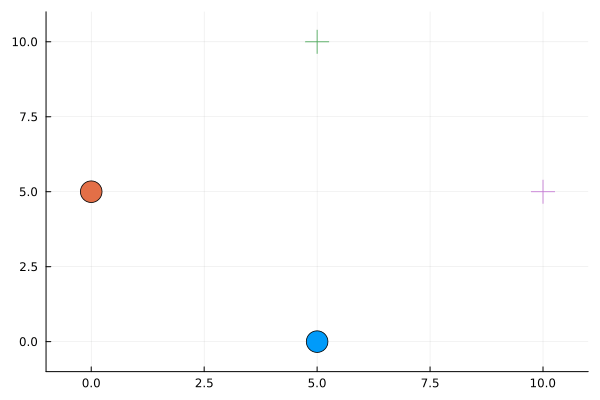

In [40]:
anim = @animate for t in 1:k_steps
    scatter([xₜ[t, :][1]], [xₜ[t, :][2]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xₜ[t, :][5]], [xₜ[t, :][6]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12))
end every 1;
gif(anim, "two_agent.gif")

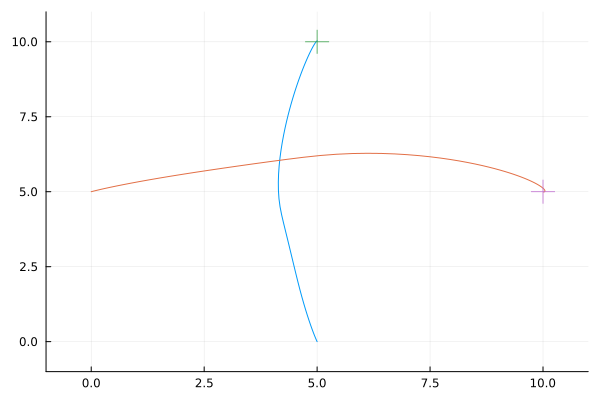

In [41]:
plot([xₜ[:, 1]], [xₜ[:, 2]], xlims = (-1, 11), ylims = (-1, 11), legend = false)
plot!([xₜ[:, 5]], [xₜ[:, 6]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12))

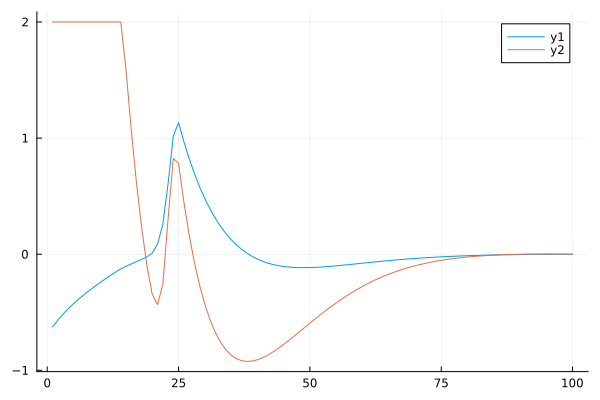

In [37]:
plot(u1ₜ)

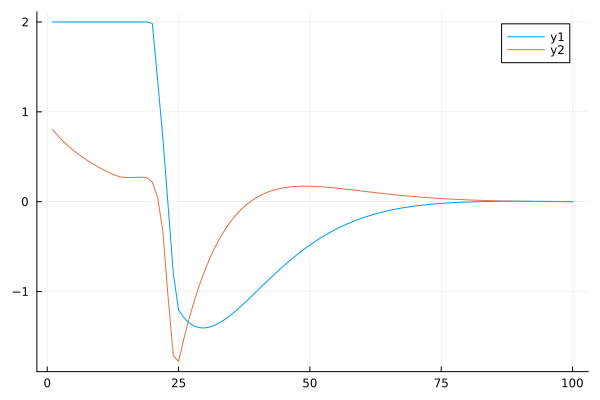

In [38]:
plot(u2ₜ)